In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import stats
import copy
widthStripesAmount=48
heightStripesAmount=64


In [69]:

class ImageManager:
    """datatype: generatedUnnoised or generatedNoised or real"""
    def __init__(self, dataType):
        self.__cloud_path_prefix = "/content/drive/My Drive/"
        #########___Data PATH___##############
        #FOR LOCAL DATA:
        #--REAL DATA:
        self._localDataset_metadata = "../data/raw/1channel/reference/epsilon.csv"
        self._localData_root_dir = "../data/raw/1channel/photo/"
        #--REAL DATA Filtered:
        self._localDataset_metadata_filtered = "../data/raw/1channel/reference/epsilon.csv"
        self._localData_root_dir_filtered = "../data/raw/1channel/medianedPhoto/"
        #--SELF-GENERATED DATA:
        #----UNNOISED
        self._localData_metadata_generated_unnoised = "../data/generated/unnoised/reference/epsilon.csv"
        self._localData_root_dir_generated_unnoised = "../data/generated/unnoised/photo/"
        #----NOISED
        self._localData_metadata_generated_noised = "../data/generated/noised/reference/epsilon.csv"
        self._localData_root_dir_generated_noised = "../data/generated/noised/photo/"
        #--MIXED-DATA:
        self._localData_metadata_generated_mixed = "../data/mixed/reference/epsilon.csv"
        self._localData_root_dir_generated_mixed = "../data/mixed/photo/"
        #--MIXED-Filtered:
        self._localData_metadata_generated_mixed_filtered = "../data/mixed/reference/epsilon.csv"
        self._localData_root_dir_generated_mixed_filtered = "../data/mixed/medianedPhoto/"

        #ON DRIVE:
        #--REAL DATA:
        self._cloudDataset_metadata = self.__cloud_path_prefix + "data/reference/real/epsilon_short.csv"
        self._cloudData_root_dir = self.__cloud_path_prefix + "data/photo/real/"
        #--SELF-GENERATED DATA:
        #----UNNOISED
        self._cloudData_metadata_generated_unnoised = self.__cloud_path_prefix + "data/reference/generated/unnoised/epsilon.csv"
        self._cloudData_root_dir_generated_unnoised = self.__cloud_path_prefix + "data/photo/generated/unnoised/"
        #----NOISED
        self._cloudData_metadata_generated_noised = self.__cloud_path_prefix + "data/reference/generated/noised/epsilon.csv"
        self._cloudData_root_dir_generated_noised = self.__cloud_path_prefix + "data/photo/generated/noised/"

        if(dataType=="generatedUnnoised"):
            self.root_dir=self._localData_root_dir_generated_unnoised
            self.annotation_file=self._localData_metadata_generated_unnoised
        elif(dataType=="generatedNoised"):
            self.root_dir=self._localData_root_dir_generated_noised
            self.annotation_file=self._localData_metadata_generated_noised
        elif(dataType=="real"):
            self.root_dir=self._localData_root_dir
            self.annotation_file=self._localDataset_metadata
        
        self.root_dir = self.root_dir
        self.annotations = pd.read_csv(self.annotation_file,skiprows=0, delim_whitespace=' ')

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        path=os.path.join(self.root_dir, str(str("%05d" %self.annotations.imgnr[index]))+ ".png")
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        epsRead = self.annotations.eps[index]
        return img, epsRead

    


324 208
ind [7 6]
maxims [12, 22, 34.125, 66.5, 103.5, 145, 200.125, 345.0000000001164, 460.125, 514, 555.5, 592.5, 617]
StripMiddle 329.5
halfMaxims [345.0000000001164, 460.125, 514, 555.5, 592.5, 617]


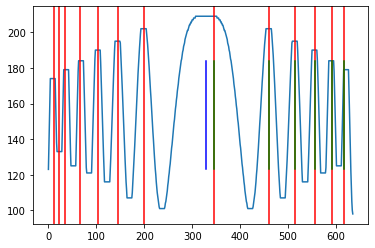

halfMaxims [15.500000000116415, 130.625, 184.5, 226.0, 263.0, 287.5]
halfMaxims [17062.890625, 34040.25, 51076.0, 69169.0, 82656.25]
a: 17006.5546875 b: 46.60416666666424


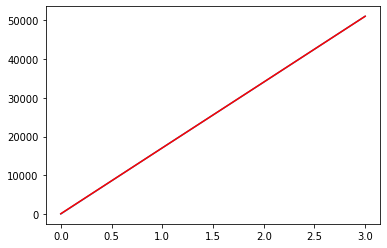

photo:  61 calc 0.0027403649665100893 target:  0.0006 diff:  -0.0021403649665100895


In [80]:
def CalculateMaxims(stripe, stripewidth,windowWidthEdge, windowWidthMiddle, meaningRadius=10, diagnose=0, threshold=10):
    diagnose=0
    if(diagnose==1): print("CalculateStripMiddle")
    imgResized=copy.deepcopy(stripe)
    imgResized=imgResized.mean(0)
    imgResizedSize=imgResized.shape[0]

    middleWidth=stripewidth/2  #Niewiadomo, dlatego centralnie środek
    meanedStripe=copy.deepcopy(imgResized) 

    for i in range (meaningRadius, imgResizedSize-meaningRadius-1):
        meanedStripe[i]=int(np.round(np.mean(imgResized[i-meaningRadius:i+meaningRadius])))

    if(diagnose==1):
        plt.plot(imgResized, color='r', label='original')
        plt.plot(meanedStripe, color='g', label='meaned')
        plt.legend()
        plt.show()
    imgResized=meanedStripe    
    maxims=[]
    for i in range (windowWidthMiddle, (imgResizedSize-windowWidthMiddle-1), 1):
        windowWidth=round(max(windowWidthMiddle-abs((middleWidth-i)/middleWidth*(windowWidthMiddle-windowWidthEdge)),windowWidthEdge))
        #print(windowWidth)
        if(imgResized[i]==max(imgResized[i-windowWidth:i+windowWidth])):
            if(len(maxims)>0 and int((maxims[-1]+windowWidth))<i):
                maxims.append(i)
            elif(len(maxims)==0):
                maxims.append(i)
            elif(int((maxims[-1]+windowWidth))>i):
                maxims[-1]=(maxims[-1]+i)/2

    return maxims

def CalculateStripMiddle(stripe, stripewidth, meaningRadius=10):
    diagnose=0
    maxims= CalculateMaxims(stripe, stripewidth,3,12, meaningRadius=meaningRadius)
    diffs=np.diff(maxims)
    ind=np.argpartition(diffs,-2)[-2:]
    if(diagnose==1):
        print("maxims", maxims)
        print("diffs", diffs)
        print("ind", ind)

    StripMiddle=0

    shift=1
    if(abs(ind[0]-ind[1])==1):
        ind0Val=abs( maxims[ind[0]]-maxims[ind[0]+1] )
        ind1Val=abs( maxims[ind[1]]-maxims[ind[1]+1] )
        if (ind0Val>ind1Val and ind0Val>1.5*ind1Val):#  or  (ind1Val>0 and ind1Val>2*ind0Val)): 
            StripMiddle=(maxims[ind[0]-shift]+maxims[ind[0]+1+shift])/2
        elif (ind1Val>ind0Val and ind1Val>1.5*ind0Val):
            StripMiddle=(maxims[ind[1]-shift]+maxims[ind[1]+1+shift])/2
        else:
            ind=np.sort(ind)
            StripMiddle=(maxims[ind[0]-shift]+maxims[ind[1]+1+shift])/2
    elif(abs(ind[0]-ind[1])==2):
        ind=np.sort(ind)
        StripMiddle=(maxims[ind[0]-shift]+maxims[ind[1]+1+shift])/2
    else:
        StripMiddle=(maxims[ind[0]-shift]+maxims[ind[0]+1]+shift)/2


    if(diagnose==1):
        print("StripMiddle", StripMiddle)
    return int(StripMiddle)

def WidthMiddleFind(img, stripesAmount):
    diagnose=0
    height, width=img.shape
    stripesMeans=[]
    for i in range (0, height-int(height/stripesAmount), int(height/stripesAmount)):
        stripe=img[i: i+int(height/stripesAmount), : ]
        
        oneStripeMean=CalculateStripMiddle(stripe, width,meaningRadius=40)
        if(diagnose==1): print("width", oneStripeMean)
        if(oneStripeMean!=-1): stripesMeans.append(oneStripeMean)
    stripesMeans=np.sort(stripesMeans)
    cutout=int(0.1*stripesAmount)
    stripesMeans=stripesMeans[cutout:len(stripesMeans)-cutout]
    widthMiddle=int(np.round(np.mean(stripesMeans)))
    return widthMiddle

def WidthHeighFind(img, stripesAmount):
    height, width=img.shape
    diagnose=0
    stripesMeans=[]
    for i in range (0, width-int(width/stripesAmount), int(width/stripesAmount)):
        stripe=img[:, i: i+int(width/stripesAmount) ]
        stripe=stripe.transpose()
        oneStripeMean=CalculateStripMiddle(stripe, height, meaningRadius=15)
        if(diagnose==1): print("height", oneStripeMean)
        if(oneStripeMean!=-1): stripesMeans.append(oneStripeMean)
    stripesMeans=np.sort(stripesMeans)
    cutout=int(0.1*stripesAmount)
    stripesMeans=stripesMeans[cutout:len(stripesMeans)-cutout]
    heightMiddle=int(np.round(np.mean(stripesMeans)))
    return heightMiddle

def FindMiddle(img, widthStripesAmount, heightStripesAmount):
    img=img[4:484, 4:644]
    
    middleWidth=WidthMiddleFind(img, widthStripesAmount)
    middleHeight=WidthHeighFind(img, heightStripesAmount)
    return middleWidth, middleHeight

def CalculateEpsilon(img, widthStripesAmount, heightStripesAmount, diagnose):
    #diagnose=0
    middleWidth, middleHeight=FindMiddle(img, widthStripesAmount, heightStripesAmount)
    #middleWidth=320
    #middleHeight=240
    if(diagnose==1):print(middleWidth, middleHeight)
    #img = cv2.imread("../data/raw/1channel/medianedphoto/00000.png", cv2.IMREAD_GRAYSCALE)
    img=img[4:484, 4:644]
    stripeWidth=img.shape[1]
    stripe=img[(middleHeight-2):(middleHeight+2),:]
    imgResizedPlot=cv2.resize(stripe, (int(stripeWidth), 1),  interpolation = cv2.INTER_AREA)[0,:]

    maxims= CalculateMaxims(stripe, stripeWidth,5,12, diagnose=diagnose, meaningRadius=13)
    
    
    if(diagnose==1):plt.plot(imgResizedPlot)
    for maxim in maxims:
        if(diagnose==1):plt.axvline(maxim,0,1, color='r')

    diffs=np.diff(maxims)
    ind=np.argpartition(diffs,-2)[-2:]

    if(diagnose==1):print("ind",ind)
    if(diagnose==1):print("maxims",maxims)

    StripMiddle=0
    shift=1
    if(abs(ind[0]-ind[1])==1):
        ind0Val=abs( maxims[ind[0]]-maxims[ind[0]+1] )
        ind1Val=abs( maxims[ind[1]]-maxims[ind[1]+1] )
        if (ind0Val>ind1Val and ind0Val>1.5*ind1Val):#  or  (ind1Val>0 and ind1Val>2*ind0Val)): 
            StripMiddle=(maxims[ind[0]-shift]+maxims[ind[0]+1+shift])/2
        elif (ind1Val>ind0Val and ind1Val>1.5*ind0Val):
            StripMiddle=(maxims[ind[1]-shift]+maxims[ind[1]+1+shift])/2
        else:
            ind=np.sort(ind)
            StripMiddle=(maxims[ind[0]-shift]+maxims[ind[1]+1+shift])/2

    elif(abs(ind[0]-ind[1])==2):
        ind=np.sort(ind)
        StripMiddle=(maxims[ind[0]-shift]+maxims[ind[1]+1+shift])/2
    else:
        StripMiddle=(maxims[ind[0]-shift]+maxims[ind[0]+1]+shift)/2
    #StripMiddle=328
    #middleHeight=240

    
    if(diagnose==1):print("StripMiddle",StripMiddle)
    halfMaxims=[i for i in maxims if i>=StripMiddle ]
    if(diagnose==1):print("halfMaxims",halfMaxims)
    if(halfMaxims[1]-halfMaxims[0]<halfMaxims[2]-halfMaxims[1]):
        halfMaxims[1]=(halfMaxims[0]+halfMaxims[1])/2
        halfMaxims.pop(0)
    for halfMaxim in halfMaxims:
        if(diagnose==1): plt.axvline(halfMaxim,0.25,0.75, color='g')
    if(diagnose==1): plt.axvline(StripMiddle, 0.25, 0.75, color='b')
    if(diagnose==1):plt.show()

    halfMaxims=[(i-StripMiddle) for i in halfMaxims]
    if(diagnose==1):print("halfMaxims",halfMaxims)
    if(halfMaxims[0]<halfMaxims[1]-halfMaxims[0]):
        halfMaxims.pop(0)
    halfMaxims=[(i*i) for i in halfMaxims]
    if(diagnose==1):print("halfMaxims",halfMaxims)
    
    halfMaxims=halfMaxims[0:len(halfMaxims)-2]
    pointsAmmount=len(halfMaxims)
    x=np.arange(1,pointsAmmount+1,1)
    
    slope, intercept, r, p, std_err = stats.linregress(x, halfMaxims)
    halfMaxims.insert(0,0)
    a=slope
    b=intercept
    print("a:", a, "b:", b)
    epsilon=abs(1-(-b/a))
    if(diagnose==1):plt.plot(halfMaxims)
    calculatedPlot=[]
    for i in range (len(halfMaxims)):
        calculatedPlot.append(i*a+b)
    if(diagnose==1):plt.plot(calculatedPlot, c='r')
    if(diagnose==1):plt.show()
    
    return epsilon, int(StripMiddle), middleHeight

def FindingMid():
    maxims=[]
    if(abs(ind[0]-ind[1])==1):
        ind0Val=abs( maxims[ind[0]]-maxims[ind[0]+1] )
        ind1Val=abs( maxims[ind[1]]-maxims[ind[1]+1] )
        if (ind0Val>ind1Val and ind0Val>1.5*ind1Val):#  or  (ind1Val>0 and ind1Val>2*ind0Val)): 
            StripMiddle=(maxims[ind[0]]+maxims[ind[0]+1])/2
        elif (ind1Val>ind0Val and ind1Val>1.5*ind0Val):
            StripMiddle=(maxims[ind[1]]+maxims[ind[1]+1])/2
        else:
            ind=np.sort(ind)
            StripMiddle=(maxims[ind[0]]+maxims[ind[1]+1])/2
        #ind=np.argpartition(diffs,-1)[-1:]
        #ind=np.argpartition(diffs,-1)[-1:]
        #StripMiddle=(maxims[ind[0]]+maxims[ind[0]+1])/2
        #StripMiddle=(maxims[min(ind)]+maxims[max(ind)])/2
    elif(abs(ind[0]-ind[1])==2):
        ind=np.sort(ind)
        StripMiddle=(maxims[ind[0]]+maxims[ind[1]+1])/2
    else:
        StripMiddle=(maxims[ind[0]]+maxims[ind[0]+1])/2
        #StripMiddle=(maxims[min(ind)]+maxims[max(ind)])/2
    #StripMiddle=middleWidth



#img = cv2.imread("../data/generated/noised/medianedphoto/00657.png", cv2.IMREAD_GRAYSCALE)
#median=cv2.medianBlur(img,21)
#mean=0
imgManager=ImageManager("generatedUnnoised")#("generatedNoised") "real"
#for i in range (imgManager.__len__()):
#    img,targetEpsilon=imgManager[i]
 #   img=cv2.medianBlur(img,21)
 #   calculatedEpsilon=CalculateEpsilon(img, widthStripesAmount, heightStripesAmount)
 #   print("calc", calculatedEpsilon, "target: ", targetEpsilon, "diff: ", targetEpsilon-calculatedEpsilon)
 #   mean+=abs(targetEpsilon-calculatedEpsilon)
#mean/=imgManager.__len__()
#print(mean)
for i in range(1):
    i=61
    img,targetEpsilon=imgManager[i]
    img=cv2.medianBlur(img,21)
    #print(targetEpsilon)
    #cv2.imshow('img',img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    calculatedEpsilon, middleWidth, middleHeight=CalculateEpsilon(img, widthStripesAmount, heightStripesAmount, diagnose=1)
    #middleWidth, middleHeight=FindMiddle(img, widthStripesAmount, heightStripesAmount)
    windowName='Image'
    centerCoordinates=(middleWidth, middleHeight)
    radius=10
    color=(255,0,0)
    thickness=-1
    img=cv2.circle(img, centerCoordinates, radius, color, thickness )
    img=cv2.circle(img, centerCoordinates, 100, color, 2 )
    img=cv2.circle(img, centerCoordinates, 200, color, 2 )
    img=cv2.circle(img, centerCoordinates, 300, color, 2 )
    print("photo: ", i, "calc", calculatedEpsilon%1, "target: ", targetEpsilon, "diff: ", targetEpsilon-calculatedEpsilon%1)
    if(targetEpsilon-calculatedEpsilon%1>0.1):
        print("Watch me!, photo ", i)
    cv2.imshow(windowName,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
#13, 17, 18, 23, 25


305 228
ind [4 5]
maxims [13, 57.5, 96.0625, 135.125, 198.25, 306.00390625, 424.25, 488.25, 525.125, 567.25, 591.125, 626]
StripMiddle 311.6875
halfMaxims [424.25, 488.25, 525.125, 567.25, 591.125, 626]


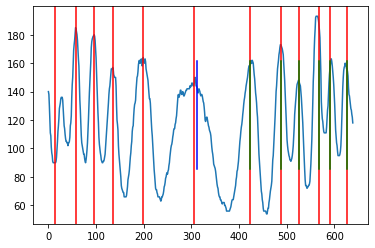

halfMaxims [112.5625, 176.5625, 213.4375, 255.5625, 279.4375, 314.3125]
halfMaxims [12670.31640625, 31174.31640625, 45555.56640625, 65312.19140625, 78085.31640625, 98792.34765625]


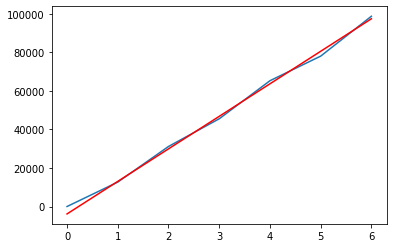

photo:  13 calc 0.7723329975186262 target:  0.742 diff:  -0.03033299751862617


In [49]:
#img = cv2.imread("../data/generated/noised/medianedphoto/00657.png", cv2.IMREAD_GRAYSCALE)
#median=cv2.medianBlur(img,21)
#mean=0
imgManager=ImageManager("real")#("generatedNoised")
#for i in range (imgManager.__len__()):
#    img,targetEpsilon=imgManager[i]
 #   img=cv2.medianBlur(img,21)
 #   calculatedEpsilon=CalculateEpsilon(img, widthStripesAmount, heightStripesAmount)
 #   print("calc", calculatedEpsilon, "target: ", targetEpsilon, "diff: ", targetEpsilon-calculatedEpsilon)
 #   mean+=abs(targetEpsilon-calculatedEpsilon)
#mean/=imgManager.__len__()
#print(mean)
for i in range(1):
    i=13
    img,targetEpsilon=imgManager[i]
    img=cv2.medianBlur(img,21)
    #print(targetEpsilon)
    #cv2.imshow('img',img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    calculatedEpsilon, middleWidth, middleHeight=CalculateEpsilon(img, widthStripesAmount, heightStripesAmount, 1)
    #middleWidth, middleHeight=FindMiddle(img, widthStripesAmount, heightStripesAmount)
    windowName='Image'
    centerCoordinates=(middleWidth, middleHeight)
    radius=10
    color=(255,0,0)
    thickness=-1
    img=cv2.circle(img, centerCoordinates, radius, color, thickness )
    img=cv2.circle(img, centerCoordinates, 100, color, 2 )
    img=cv2.circle(img, centerCoordinates, 200, color, 2 )
    img=cv2.circle(img, centerCoordinates, 300, color, 2 )
    print("photo: ", i, "calc", calculatedEpsilon%1, "target: ", targetEpsilon, "diff: ", targetEpsilon-calculatedEpsilon%1)
    if(targetEpsilon-calculatedEpsilon%1>0.1):
        print("Watch me!, photo ", i)
    cv2.imshow(windowName,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
#13, 17, 18, 23, 25

